In [1]:
from pathlib import Path
import time
from itertools import product

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.ndimage import gaussian_filter, rotate

import torch
from tqdm.auto import tqdm

import sklearn.cluster as skc
from torch_dct import dct_2d
from scipy.ndimage import zoom

from sklearn import metrics

import neuralarpes as na
from neuralarpes import transform as tr

import dataloader as dl

# fix random number generator

In [2]:
seed = 192
rng = np.random.default_rng(seed)

# Load Dataset

In [7]:
filepath = Path(r"D:\data\ARPES_on_the_fly\datasets\processed\gr_flake_256.h5")
if not filepath.exists():
    filepath = Path(r"D:\data\ARPES-on-the-fly\datasets\processed\gr_flake_256.h5")
assert filepath.exists()
loaded = dl.load(filepath)

Loaded data using H5Loader


In [8]:
xarr = loaded.to_xarray()

In [9]:
xarr = xarr.compute()

In [10]:
xarr = xarr.transpose("posx", "posy", "energy", "angle").sortby(["energy", "angle","posx","posy"])

In [11]:
xarr

<xarray.DataArray 'array-e174246cb568bfbcb207c5b52d6fc123' (posx: 49, posy: 39,
                                                            energy: 256,
                                                            angle: 256)>
array([[[[ 1.13616133e+00,  1.06722450e+00,  1.09053481e+00, ...,
           9.35172677e-01,  1.12791491e+00,  8.38642478e-01],
         [ 8.77832234e-01,  3.47427785e-01,  4.68595088e-01, ...,
           6.44002199e-01,  8.49212646e-01,  1.17347002e+00],
         [ 1.27698600e+00,  8.44127893e-01,  5.23211598e-01, ...,
           7.66472459e-01,  1.63604856e+00,  8.85518014e-01],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.31862494e-03,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 2.22194791e+00,  1.30373192e+00,  1.68375111e+00, ...,
           3.58516955e+00,  1.50501609e+00,  1.22973502e+00],
         [ 8.87760222e-01,  2.31875753e+00,  2.09663701e+00, ...,
           3.39271474e+00,  2.75521326e+00,  2.56226945e+00],
         [ 9.07770216e-01,  5.46551883e-01,  1.05513489e+00, ...,
           1.50854504e+00,  1.21974707e+00,  1.57674682e+00],
...
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 2.55728006e-01,  1.40414387e-01,  5.00370920e-01, ...,
           3.52007240e-01,  1.59460306e-01,  1.95422083e-01],
         [ 4.24637645e-01,  0.00000000e+00,  3.66639309e-02, ...,
           0.00000000e+00,  3.17048401e-01,  4.17480648e-01],
         [ 5.29498935e-01,  7.49746710e-02,  6.86775863e-01, ...,
           0.00000000e+00,  0.00000000e+00,  5.85312247e-01],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]],
      dtype=float32)
Coordinates:
  * posx     (posx) int32 0 1 2 3 4 5 6 7 8 9 ... 39 40 41 42 43 44 45 46 47 48
  * posy     (posy) int32 0 1 2 3 4 5 6 7 8 9 ... 29 30 31 32 33 34 35 36 37 38
  * angle    (angle) int32 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * energy   (energy) int32 0 1 2 3 4 5 6 7 ... 248 249 250 251 252 253 254 255

# Define parameters

In [12]:
transform = [
    tr.ToTensor(), 
    tr.Resize((256,256)), 
    tr.SetPoissonExposure(100_000),
    tr.NormalizeMinMax(0,100)
]
transform_nonoise =[
    tr.ToTensor(),
    tr.Resize((256,256)), 
    tr.NormalizeMinMax(0,100)
]

# preview

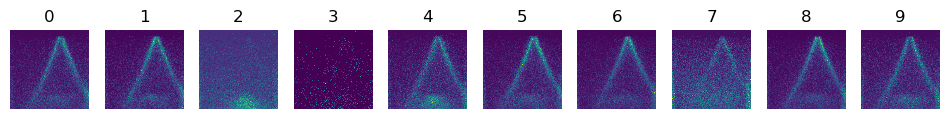

In [13]:
N = 10
fig, ax = plt.subplots(1,N,figsize=(12,3))
ix,iy = np.random.randint(0, 49, N), np.random.randint(0, 39, N)
imgs = [xarr.isel(posx=i, posy=j).values for i,j in zip(ix,iy)]
for i,img in enumerate(imgs):
    # img = tr.pipe(cut.values,transform_nonoise).numpy()
    ax[i].imshow(img, cmap='viridis', interpolation='none',origin='lower',aspect='equal')
    ax[i].set_title(f'{i}')
    ax[i].set_xlabel('ky')
    ax[i].set_ylabel('E')
    #turn off axis
    ax[i].axis('off')




In [17]:
aenc_dir = Path(r"D:\data\ARPESdatabase\results")
assert aenc_dir.exists()
autoencoders = {
    "simple": aenc_dir/r"arpesnet256_simple\arpesnet_20240426-082929_e1000.pth",
    "denoiser": aenc_dir/r"arpesnet256_denoiser\arpesnet_20240425-185618_e1000.pth",
    "noise": aenc_dir/r"arpesnet256_noise\arpesnet_20240425-224442_e1000.pth",
    "4k": aenc_dir/r"arpesnet256_noise_20k\arpesnet_e4000.pth",    
}
for n, v in autoencoders.items():
    assert Path(v).exists(), f"{v} does not exist"
    autoencoders[n] = na.load_trainer(v)

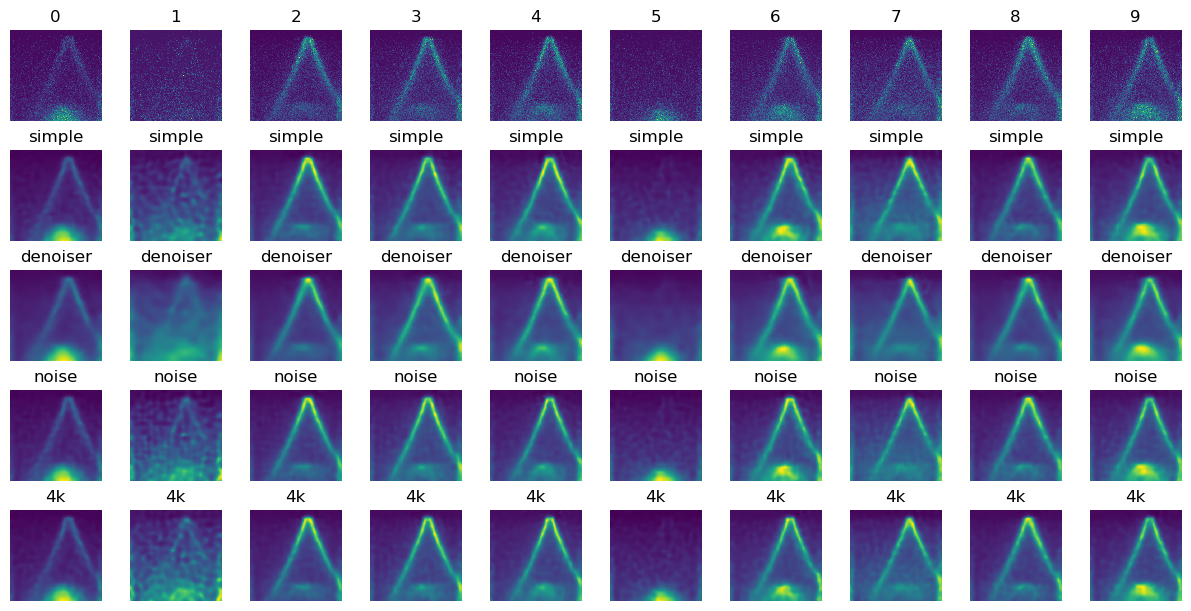

In [ ]:
N=10
fig, ax = plt.subplots(1+len(autoencoders),N,figsize=(12,6),layout='constrained')

ix,iy = np.random.randint(0, 49, N), np.random.randint(0, 39, N)
imgs = [xarr.isel(posx=i, posy=j).values for i,j in zip(ix,iy)]

rec = {}
for k,v in autoencoders.items():
    rec[k] = [v.eval(tr.pipe(img,transform_nonoise)) for img in imgs]

for i,img in enumerate(imgs):
    # img = tr.pipe(cut.values,transform_nonoise).numpy()
    ax[0,i].imshow(img, cmap='viridis', interpolation='none',origin='lower',aspect='equal')
    ax[0,i].set_title(f'{i}')
    ax[0,i].axis('off')
    for j,(k,v) in enumerate(rec.items()):
        ax[j+1,i].imshow(v[i], cmap='viridis', interpolation='none',origin='lower',aspect='equal')
        ax[j+1,i].set_title(f'{k}')
        ax[j+1,i].axis('off')


# prepare data for clustering

In [ ]:
spectra = xarr.values.reshape((-1,256,256))
data = {'raw':[], 'DCT32':[], 'simple':[], 'denoiser':[], 'noise':[], '4k':[]}
times = {'raw':[], 'DCT32':[], 'simple':[], 'denoiser':[], 'noise':[], '4k':[]}
for sp in tqdm(spectra):
    tsp = tr.Compose(transform_nonoise)(sp).to('cuda')
    t0 = time.time()
    data['raw'].append(tsp.flatten().squeeze().detach().cpu().numpy())
    times['raw'].append(time.time()-t0)
    t0=time.time()
    data['DCT32'].append(dct_2d(tsp)[:32,:32].flatten().squeeze().detach().cpu().numpy())
    times['DCT32'].append(time.time()-t0)
    for k,v in autoencoders.items():
        t0 = time.time()
        data[k].append(v.encode(tsp).flatten().squeeze().detach().cpu().numpy())
        times[k].append(time.time()-t0)
data = {k:np.array(v) for k,v in data.items()}

  0%|          | 0/1911 [00:00<?, ?it/s]

In [20]:
for k in times.keys():
    t = times[k]
    d = data[k]
    print(f"{k:10s}: {np.sum(t):.2f}s | {d.shape}")

raw       : 0.20s | (1911, 65536)
DCT32     : 1.84s | (1911, 1024)
simple    : 1.72s | (1911, 512)
denoiser  : 1.65s | (1911, 512)
noise     : 1.67s | (1911, 512)
4k        : 1.64s | (1911, 512)


# clustering

In [21]:
kres = {}
ktime = {}
n_clusters = 10
init_idxs = skc.kmeans_plusplus(data['raw'], n_clusters, random_state=seed)[1]
for k,v in tqdm(data.items()):
    t0 = time.time()
    init_clusters = v[init_idxs]
    km = skc.KMeans(n_clusters=n_clusters, init=init_clusters)
    kres[k] = km.fit(v)
    ktime[k] = time.time()-t0

  0%|          | 0/6 [00:00<?, ?it/s]

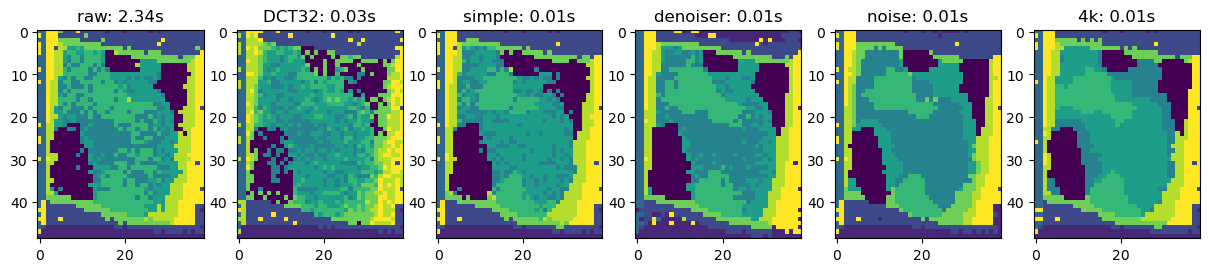

In [22]:
fig,ax = plt.subplots(1,6, figsize=(15,3))
shape = (49,39)
for i,(k,v) in enumerate(kres.items()):

    ax[i].imshow(v.labels_.reshape(shape),cmap='viridis',aspect='equal')
    ax[i].set_title(f"{k}: {ktime[k]:.2f}s")

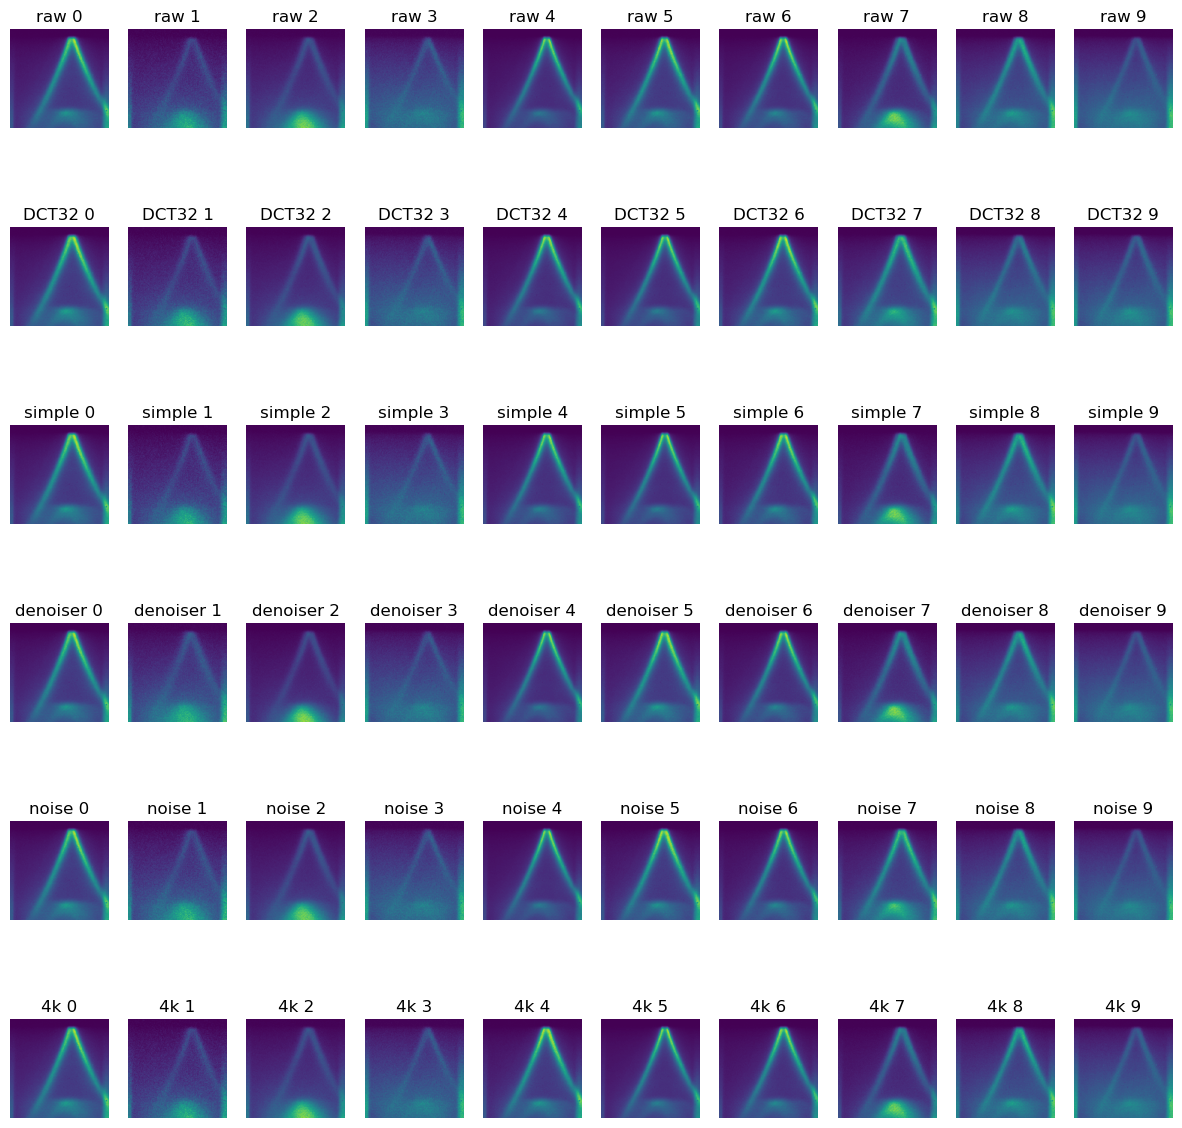

In [23]:
fig, ax = plt.subplots(len(kres),n_clusters,figsize=(15,15))
for i, (k, v) in enumerate(kres.items()):
    centers = [np.mean(data['raw'][v.labels_==i],axis=0) for i in range(n_clusters)]
    for j, c in enumerate(centers):
        ax[i,j].imshow(c.reshape((256,256)),cmap='viridis',aspect='equal',origin='lower')
        ax[i,j].axis('off')
        ax[i,j].set_title(f"{k} {j}")



In [24]:
# border pre-selection

1


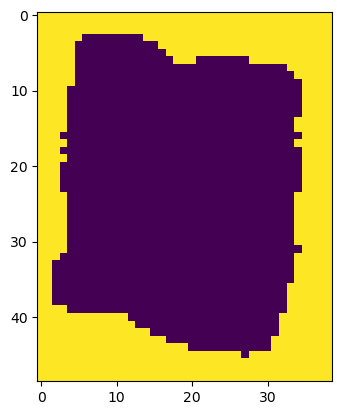

In [35]:

n_clusters = 2
km = skc.KMeans(n_clusters=n_clusters)
filter_res = km.fit(data['4k'])
plt.figure()
plt.imshow(filter_res.labels_.reshape(shape),cmap='viridis',aspect='equal')
print(filter_res.labels_.reshape(shape)[0,0])

In [36]:
# masked_spectra = xarr.values.reshape((-1,256,256))
# masked_spectra[filter_res.labels_.reshape(shape)==0] = np.zeros((256,256))


In [37]:
filter_res.labels_.shape
spectra = xarr.values.reshape((-1,256,256))
spectra.shape, filter_res.labels_.shape


((1911, 256, 256), (1911,))

In [40]:
spectra = xarr.values.reshape((-1,256,256))
data = {'raw':[], 'DCT32':[], 'simple':[], 'denoiser':[], 'noise':[], '4k':[]}
times = {'raw':[], 'DCT32':[], 'simple':[], 'denoiser':[], 'noise':[], '4k':[]}
for sp, mask in tqdm(zip(spectra, filter_res.labels_)):
    if mask == 1:
        data['raw'].append(np.zeros((256,256)).flatten())
        data['DCT32'].append(np.zeros((1024)).flatten())
        for k,v in autoencoders.items():
            data[k].append(np.zeros((512)).flatten())
    else:
        tsp = tr.Compose(transform_nonoise)(sp).to('cuda')
        t0 = time.time()
        data['raw'].append(tsp.flatten().squeeze().detach().cpu().numpy())
        times['raw'].append(time.time()-t0)
        t0=time.time()
        data['DCT32'].append(dct_2d(tsp)[:32,:32].flatten().squeeze().detach().cpu().numpy())
        times['DCT32'].append(time.time()-t0)

        for k,v in autoencoders.items():
            # if k == '4k':
            #     t0 = time.time()
            #     data[k].append(v.encode(tsp).flatten().squeeze().detach().cpu().numpy())
            #     times[k].append(time.time()-t0)
            t0 = time.time()
            data[k].append(v.encode(tsp).flatten().squeeze().detach().cpu().numpy())
            times[k].append(time.time()-t0)
data = {k:np.array(v) for k,v in data.items()}

0it [00:00, ?it/s]

# cluster masked data

In [41]:
kres = {}
ktime = {}
n_clusters = 8
init_idxs = skc.kmeans_plusplus(data['raw'], n_clusters, random_state=seed)[1]
for k,v in tqdm(data.items()):
    t0 = time.time()
    init_clusters = v[init_idxs]
    km = skc.KMeans(n_clusters=n_clusters, init=init_clusters)
    kres[k] = km.fit(v)
    ktime[k] = time.time()-t0

  0%|          | 0/6 [00:00<?, ?it/s]

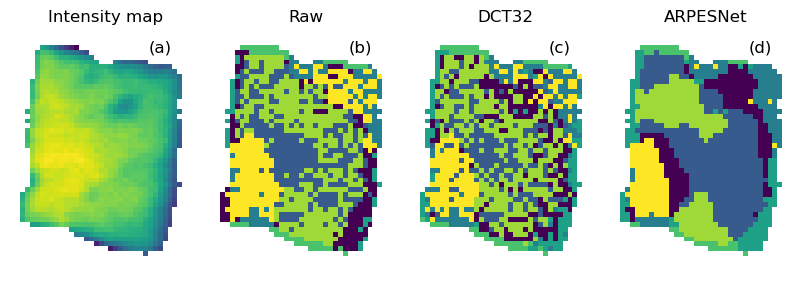

In [ ]:
fig,ax = plt.subplots(1,4, figsize=(8,3),layout='constrained')
shape = (49,39)
selected = {k:v for k,v in kres.items() if k not in ['simple','noise','denoiser']}
for i_,(k,v) in enumerate(selected.items()):
    i = i_ +1
    img = v.labels_.reshape(shape).astype(float)
    img[img==img[0,0]] = np.nan
    ax[i].imshow(img,cmap='viridis',aspect='equal')#,origin='lower')
    if k == '4k':
        ax[i].set_title(f"ARPESNet")
    elif k == 'raw':
        ax[i].set_title(f"Raw")
    else:
        ax[i].set_title(f"{k}")
    ax[i].axis('off')
    ax[i].text(30,3,f"({'abcdefghijklmnopq'[i]})",color='k',fontsize=12,ha='center', va='center')
imap = xarr.sum(['energy','angle'])
imap.values[filter_res.labels_.reshape(shape) == 1] = np.nan #edge filter
ax[0].imshow(imap.values,cmap='viridis',aspect='equal')#,origin='lower')
# imap.plot.imshow(ax=ax[0], cmap='viridis', robust=True, add_colorbar=False)
ax[0].set_title('Intensity map')
ax[0].axis('off')
ax[0].text(30,3,f"(a)",color='k',fontsize=12,ha='center', va='center')
fig.savefig('figs/fig7_panels.svg',dpi=300, bbox_inches='tight', transparent=True, format='svg')


In [61]:
xarr.isel(
    posx=np.random.randint(0, 49, 1), 
    posy=np.random.randint(0, 39, 1),
).squeeze()

<xarray.DataArray 'array-e174246cb568bfbcb207c5b52d6fc123' (energy: 256,
                                                            angle: 256)>
array([[ 1.02978718e+00,  7.29078412e-01,  3.60915214e-01, ...,
         2.56271648e+00,  1.48932648e+00,  1.68657267e+00],
       [ 1.26431084e+00,  7.42006719e-01,  4.73936200e-01, ...,
         1.73786736e+00,  1.85725558e+00,  1.75711298e+00],
       [ 5.36944032e-01,  3.72441232e-01,  4.41348076e-01, ...,
         1.22068572e+00,  2.38877249e+00,  2.13226938e+00],
       ...,
       [ 7.77685344e-02,  0.00000000e+00,  0.00000000e+00, ...,
         1.27671675e-11,  1.06168960e-13,  1.10214558e-13],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.74583765e-04,  3.45963490e-05, -4.76288142e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.74858631e-03,  1.27469437e-04, -1.75486712e-05]], dtype=float32)
Coordinates:
    posx     int32 14
    posy     int32 21
  * angle    (angle) int32 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * energy   (energy) int32 0 1 2 3 4 5 6 7 ... 248 249 250 251 252 253 254 255

[17] [28]


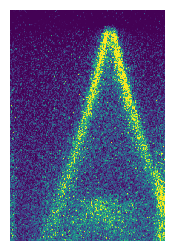

In [100]:
N = 10
fig, ax = plt.subplots(1,1,figsize=(2,3))
x,y = [17], [28]#np.random.randint(0, 49, 1), np.random.randint(0, 39, 1)
img = xarr.isel(posx=x, posy=y)
img -= img.min()
# img /= img.max()
img.squeeze().plot.imshow(ax=ax, cmap='viridis', robust=True, add_colorbar=False)
ax.set_title('')
ax.axis('off')
print(x,y)
fig.savefig('figs/fig7_panel_a.svg',dpi=300, bbox_inches='tight', transparent=True, format='svg')

